In [1]:
import uproot as up 
import numpy as np
from pylab import figure, cm
from matplotlib.colors import LogNorm


In [2]:

quark_events   = up.open("/data/santosh/qgdata/R4_50_75GeV/quark50.root")['ntuple']
gluon_events   = up.open("/data/santosh/qgdata/R4_50_75GeV/gluon50_skim_events.root")['ntuple']

quark_events.keys()

[b'emtopo_pt_matched',
 b'emtopo_eta_matched',
 b'emtopo_phi_matched',
 b'emtopo_m_matched',
 b'emtopo_nConstituents_matched',
 b'emtopo_partonTruthLabel_matched',
 b'emtopo_constituentEt_matched',
 b'emtopo_constituentEta_matched',
 b'emtopo_constituentPhi_matched',
 b'truth_pt_matched',
 b'truth_eta_matched',
 b'truth_phi_matched',
 b'truth_m_matched',
 b'truth_nConstituents_matched',
 b'truth_partonTruthLabel_matched',
 b'truth_constituentEt_matched',
 b'truth_constituentEta_matched',
 b'truth_constituentPhi_matched']

In [3]:
#df_tt   = ttbar_events.pandas.df(flatten=False)
#df_ztt  = ztt_events.pandas.df(flatten=False)
df_quark  = quark_events.pandas.df(flatten=False)
df_gluon  = gluon_events.pandas.df(flatten=False)

In [4]:
len(df_quark)

65611

In [5]:
len(df_gluon)

65611

Text(0.5, 0, 'pT')

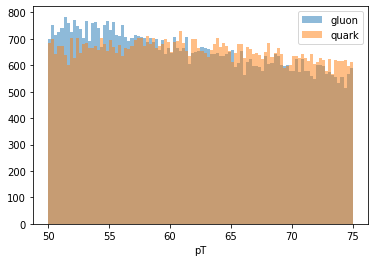

In [6]:
import matplotlib.pyplot as plt
plt.hist(df_gluon['emtopo_pt_matched']/1e3,bins=100,alpha=0.5,label='gluon')
plt.hist(df_quark['emtopo_pt_matched']/1e3,bins=100,alpha=0.5,label='quark')
plt.legend()
plt.xlabel('pT')

Text(0.5, 0, 'jetConstituents')

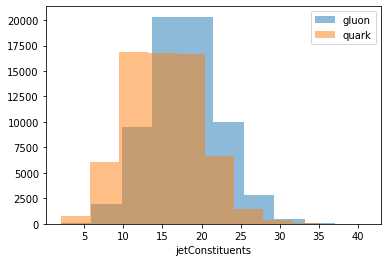

In [7]:
plt.hist(df_gluon['emtopo_nConstituents_matched'],bins=10,alpha=0.5,label='gluon')
plt.hist(df_quark['emtopo_nConstituents_matched'],bins=10,alpha=0.5,label='quark')
plt.legend()
plt.xlabel('jetConstituents')

Text(0.5, 0, 'eta')

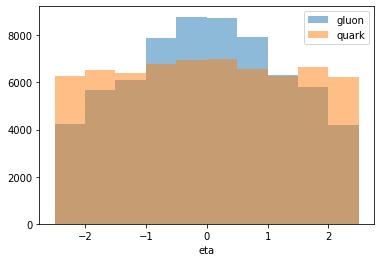

In [8]:
plt.hist(df_gluon['emtopo_eta_matched'],alpha=0.5,label='gluon')
plt.hist(df_quark['emtopo_eta_matched'],alpha=0.5,label='quark')
plt.legend()
plt.xlabel('eta')

Text(0.5, 0, 'phi')

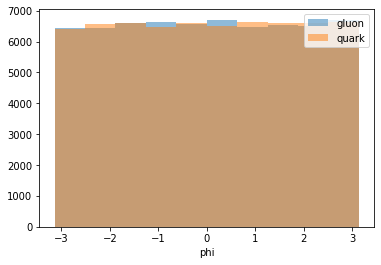

In [9]:
plt.hist(df_gluon['emtopo_phi_matched'],alpha=0.5,label='gluon')
plt.hist(df_quark['emtopo_phi_matched'],alpha=0.5,label='quark')
#plt.xlim(-2, 22)
plt.legend()
plt.xlabel('phi')

Text(0.5, 0, 'partonTruthLabel')

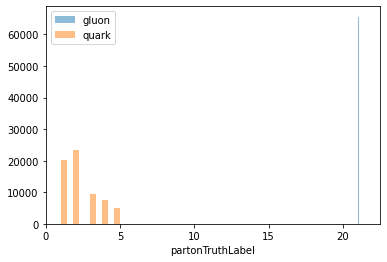

In [10]:
plt.hist(df_gluon['emtopo_partonTruthLabel_matched'],alpha=0.5,label='gluon')
plt.hist(df_quark['emtopo_partonTruthLabel_matched'],alpha=0.5,label='quark')
#plt.xlim(-2, 22)
plt.legend()
plt.xlabel('partonTruthLabel')
#plt.yscale('log')

In [11]:
#arrays = quark_events.arrays()
arrays = gluon_events.arrays()

In [12]:
def translate(jet_eta,jet_phi, arr_clusEta, arr_clusPhi,idx):
    tmp_clusEta = arr_clusEta
    tmp_clusPhi = arr_clusPhi

    for i,e in enumerate(arr_clusPhi):
         tmp_clusPhi[i] = extend_phi(tmp_clusPhi[i], jet_phi)

    for i,e in enumerate(arr_clusEta):
        tmp_clusEta[i] = arr_clusEta[i] - jet_eta
        tmp_clusPhi[i] = arr_clusPhi[i] - jet_phi

    return (tmp_clusEta, tmp_clusPhi)

In [13]:
def extend_phi(phi, jet_phi):
    """
    If a jet center is close to either 0 or 2*pi, its constituents could be on the other side
    of the periodicity line. This takes care of this problem by remapping phi to be either
    above 2*pi or below zero.
    """
    if abs(jet_phi + np.pi)<1.: # phi close to -pi
        return phi-2*np.pi*int(abs(phi-np.pi) <1-abs(jet_phi + np.pi))
    elif abs(jet_phi - np.pi)<1.: # phi close to pi
        return phi+2*np.pi*int(abs(-phi-np.pi) < 1-abs(jet_phi - np.pi)) 
    else: 
        return phi

In [14]:
#def pixelize(data, edges, cutoff=0.1):
#    """Return eta-phi histogram of transverse energy deposits.
#    Optionally set all instensities below cutoff to zero.
#    """
#    image, _, _ = np.histogram2d(
#        data[0],data[1],   #Eta and phi
#        bins=(edges[0], edges[1]), # bin edges #
#        weights=data[2] * (data[2] > cutoff)) # bin weights with cutoff
#    return image

In [15]:
def getJetImages(dff):
    eta = noTranslate(dff,['emtopo_constituentEta_matched','emtopo_constituentPhi_matched'])[0]
    phi = noTranslate(dff,['emtopo_constituentEt_matched','emtopo_constituentPhi_matched'])[1]
    eng = dff.AntiKt10LCTopoLeadJets_clus_calE.values
    
    edges = pixel_edges()
    li_images = []
    for i in range(eta.shape[0]):
        li_images.append(pixelize([eta[i],phi[i],eng[i]],edges))
    return li_images

In [16]:
def pixel_edges(jet_size=0.4, pixel_size=(0.055, 0.055), border_size=0.001):
#def pixel_edges(jet_size=1.0, pixel_size=(0.2, 0.2), border_size=0.5):
#def pixel_edges(jet_size=1.0, pixel_size=(0.1, 0.1), border_size=0.0):
    """Return pixel edges required to contain all clusters.
    border_size is interpreted as a fraction of the jet_size
    """
    im_edge = (1. + border_size) * jet_size
    return (np.arange(-im_edge, im_edge+pixel_size[0], pixel_size[0]), np.arange(-im_edge, im_edge+pixel_size[1], pixel_size[1]))


In [17]:
def createImage(data, edges, cutoff=0.1):
    """Return eta-phi histogram of transverse energy deposits.
    Optionally set all instensities below cutoff to zero.
    """
    image, _, _ = np.histogram2d(
        data[0],data[1],
        bins=(edges[0], edges[1]),
        weights=data[2] * (data[2] > cutoff))
    return image 

In [18]:
def normalize(histo, multi=255):
    """
    Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
    """
    return (histo/np.max(histo)*multi).astype(int)

In [19]:
pack = zip(arrays[b'emtopo_partonTruthLabel_matched'],arrays[b'emtopo_pt_matched'], arrays[b'emtopo_eta_matched'], arrays[b'emtopo_phi_matched'], arrays[b'emtopo_constituentEta_matched'], arrays[b'emtopo_constituentPhi_matched'], arrays[b'emtopo_constituentEt_matched'])

In [20]:
#pack = zip(df_gluon['AntiKt10LCTopoLeadJets_partonTruthLabel'], df_gluon['AntiKt10LCTopoLeadJets_pt'], df_gluon['AntiKt10LCTopoLeadJets_eta'], df_gluon['AntiKt10LCTopoLeadJets_phi'], df_gluon['AntiKt10LCTopoLeadJets_clus_calEta'], df_gluon['AntiKt10LCTopoLeadJets_clus_calPhi'], df_gluon['AntiKt10LCTopoLeadJets_clus_calE'])

In [21]:
def getNonDuplicateSubArrayMaxIdx(array):
    # Implementation using two pointer algorithm technique
    left = 0
    val = array[left]
    for right in range(1,len(array)):
        while  val != array[right]:
            left += 1
            val = array[left]
        
    return left

In [22]:
image_li = []
for i, (trth,jet_pt,jet_eta,jet_phi, clus_eta, clus_phi, clus_E) in enumerate(pack):
    idx      = getNonDuplicateSubArrayMaxIdx(clus_eta)
    clus_eta = clus_eta[:idx]
    clus_phi = clus_phi[:idx]
    clus_E   = clus_E[:idx]
    if len(clus_E)==0:
       #print("Skipping event due to empty clus_E")
       continue
    else:
         max_idx=np.argsort(clus_E)[-1]      
   


    clus_eta,clus_phi = translate(jet_eta,jet_phi,clus_eta,clus_phi,max_idx)
    etaedges,phiedges = pixel_edges()

    img = createImage((clus_eta,clus_phi,clus_E), (etaedges,phiedges), )
    img = normalize(img)
    image_li.append(img)

#img = np.average(image_li,axis=0)
#plt.imshow(img)#, norm=matplotlib.colors.LogNorm())
#im = plt.imshow(img, norm=LogNorm())
#plt.imshow(img, norm=LogNorm())
#plt.colorbar(im)
#plt.xlabel(r'$\eta$')
#plt.ylabel(r'$\phi$')
#plt.show()

In [23]:
num_images = len(image_li)
print(f"There are {num_images} images in the list.")

There are 65611 images in the list.


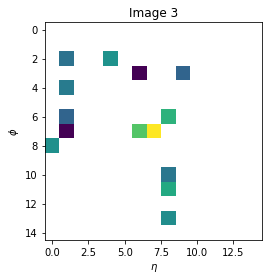

In [24]:
import matplotlib.pyplot as plt

# plot the third image in the list
im1=plt.imshow(image_li[32046], norm=LogNorm())
plt.title("Image 3")
#plt.colorbar(im1)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
# show the plot
plt.show()


In [1]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from numpy import load 
import numpy as np 

quark_sample 	= load('quark_leading_jet.npz')['arr_0']
gluon_sample 	= load('gluon_leading_jet.npz')['arr_0']

x_data 		= np.concatenate( (quark_sample, gluon_sample) )
x_data          = x_data.reshape(x_data.shape + (1,)).astype('float32')
x_data          /=255.

y_data          = np.array([0]*len(gluon_sample) + [1]*len(quark_sample))

y_data          = keras.utils.to_categorical(y_data,2)

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data)


import h5py
h5 = h5py.File('jetImages.h5','w')
h5.create_dataset("x_train",data=x_train)
h5.create_dataset("x_test",data=x_test)
h5.create_dataset("y_train",data=y_train)
h5.create_dataset("y_test",data=y_test)
h5.close()

2023-05-04 12:05:20.459405: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
len(quark_sample)

65611

In [3]:
len(gluon_sample)

65611

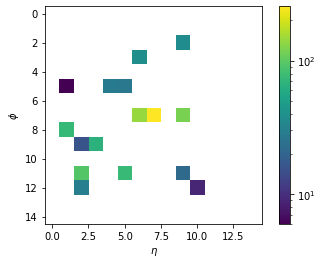

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

im1=plt.imshow(gluon_sample[920], norm=LogNorm())
plt.colorbar(im1)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.show()
#plt.savefig('quark.png')
#plt.savefig('gluon.png')